In [1]:
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})

from definitions import ROOT_DIR
from unc.utils import load_info

/Users/ruoyutao/Documents/uncertainty/venv/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
# COLORS

emerald = "#2ecc71"
turquoise = "#1abc9c"
peter_river = "#3498db"
sunflower = "#f1c40f"
alizarin = "#e74c3c"
pumpkin = "#d35400"
green_sea = "#16a085"
wisteria = "#8e44ad"
midnight_blue = "#2c3e50"


In [3]:
level = 4
# all_paths = {
# #     f'uf{level}a_cnn': Path(ROOT_DIR, 'results', f'uf{level}a_cnn'),
#     f'uf{level}m_cnn':  Path(ROOT_DIR, 'results', 'uf8_sweep_4m', f'uf{level}m_cnn'),
#     f'uf{level}m_cnn_lstm':  Path(ROOT_DIR, 'results', 'uf8_sweep_4m', f'uf{level}m_cnn_lstm'),
# }
# results_dir = Path(ROOT_DIR, 'results')
results_dir = Path(ROOT_DIR, 'results', 'results_uf4_no_buff')

# results_dir = Path(ROOT_DIR, 'results_full_uf8')

all_paths = {
    f'uf{level}a_cnn': results_dir / f'uf{level}a_cnn',
    f'uf{level}m_cnn':  results_dir / f'uf{level}m_cnn',
    f'uf{level}m_cnn_lstm':  results_dir / f'uf{level}m_cnn_lstm',
}

plot_info = {
    f'uf{level}a_cnn': {'color': midnight_blue, 'label': 'Ground-truth'},
    f'uf{level}m_cnn_lstm': {'color': sunflower, 'label': 'LSTM'},
    f'uf{level}m_cnn_lstm_unc': {'color': wisteria, 'label': 'LSTM + Aux inputs'},
    f'uf{level}m_cnn': {'color': green_sea, 'label': 'Normal'},
    f'uf{level}m_cnn_unc': {'color': pumpkin, 'label': 'Aux inputs'}
}

plot_order = [
    f'uf{level}a_cnn',
    f'uf{level}m_cnn',
    f'uf{level}m_cnn_lstm',
    f'uf{level}m_cnn_unc',
    f'uf{level}m_cnn_lstm_unc'
]
split_by = ['buffer_size', 'step_size', 'arch', 'uncertainty_decay', 'slip_prob', 'trunc', 'total_steps']
Args = namedtuple('args', split_by)


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [4]:
def process_dir(dir_path, split_by, w=10):
    all_results = {}

        
    for f in tqdm(list(dir_path.iterdir())):
        if f.suffix != ".npy":
            continue
        info = load_info(f)
        args = info['args'].item()
        if "arch" not in args:
            args['arch'] = 'nn'
            
#         if args['trunc'] > 10:
#             continue
        
#         if args['total_steps'] < 12e6:
#             continue
            
#         if args["arch"] == "cnn_lstm" and args["uncertainty_decay"] < 1.:
#             continue
#         if args["total_steps"] < 4e6:
#             continue
            
        
        reward = info['reward']
        offline_key = 'offline_eval_reward'
        if 'offline_eval_returns' in info:
            offline_key = 'offline_eval_returns'
        offline_returns = info[offline_key]

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

        all_results[hparams].append((reward, offline_returns, args, f))


    
    return all_results

    

In [5]:
def group_by(dataset, key, label_head, groups=None, add_labels=None):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)

        if groups is not None:
            assert add_labels is not None and len(add_labels) == len(groups)
            full_label = label_head
            grouped = False
            none_idx = None
            
            for i, g in enumerate(groups):
                add_label = False
                
                if g is not None and key_val in g:
                    if add_labels[i] is not None:
                        full_label += f'_{add_labels[none_idx]}' 
                    grouped = True
                    break
                elif g is None:
                    none_idx = i
                    
            if not grouped:
                if none_idx is None:
                    print(f"skipping {key_val}")
                else:
                    if add_labels[i] is not None:
                        full_label += f'_{add_labels[none_idx]}'
        else:     
            full_label = label_head + f'_{key}_{key_val}'
            
        if full_label not in grouped_data:
            grouped_data[full_label] = {}
        
        grouped_data[full_label][args] = d
    return grouped_data


In [6]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    raw_data[key] = processed

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/385 [00:00<?, ?it/s]

In [7]:
arg_example = list(raw_data[f'uf{level}m_cnn'].values())[0][0][2]
steps_per_eval = arg_example['offline_eval_freq']


In [8]:
key = 'uncertainty_decay'
split_files = [f'uf{level}m_cnn', f'uf{level}m_cnn_lstm']
unc_decay_groups = [[1.], None]
additional_labels = [None, 'unc']

new_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file, groups=unc_decay_groups, add_labels=additional_labels)
    for k, v in new_grouped.items():
        new_raw[k] = v
        
for k, v in raw_data.items():
    if k not in split_files:
        new_raw[k] = v

In [9]:
no_slip_raw = {}
slip_raw = {}

for k, v in new_raw.items():
    new_v_slip = {}
    new_v_no_slip = {}
    
    for k_arg, v_arg in v.items():
        if k_arg.slip_prob > 0.:
            new_v_slip[k_arg] = v_arg
        else:
            new_v_no_slip[k_arg] = v_arg
    slip_raw[k] = new_v_slip
    no_slip_raw[k] = new_v_no_slip

In [10]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(offline_rew[-eps_max_over:]) for online_rew, offline_rew, all_args, fname in all_dis_rew])
#         final_max = np.mean([np.mean(offline_rew) for online_rew, offline_rew, all_args, fname in all_dis_rew])

        fnames = [fname for _, _, _, fname in all_dis_rew]
        hparam_results.append((args, final_max, fnames))
    return hparam_results



In [11]:
max_overs_slip = {}

for g, v in slip_raw.items():
    max_overs_slip[g] = get_eps_max_over(v, eps_max_over=100)
    

In [12]:
# Get the best hyperparams based on the final 100 episodes
all_best_slip = {}
for key, v in max_overs_slip.items():
    all_best_slip[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

all_best_slip

{'uf4m_cnn': (args(buffer_size=20000, step_size=1e-05, arch='cnn', uncertainty_decay=1.0, slip_prob=0.1, trunc=10, total_steps=2000000),
  19.2572,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn/c4effaf7cebdef7044d92d2eba17da8d_Tue Aug  9 10:58:35 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn/2e7a5a3b992462905747bb63bd1f1ecd_Tue Aug  9 10:58:35 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn/03d0971ecc3dcc7551a6a83fad6f8e63_Tue Aug  9 10:58:35 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn/fd14b26c28fd46c1db19117739b9c9ed_Tue Aug  9 10:58:35 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn/8fa91cd0d817f03bf5baa1e34d39f580_Tue Aug  9 10:58:35 2022.npy')]),
 'uf4m_cnn_unc': (args(buffer_size=20000, step_size=0.0001, arch='cnn', uncertai

In [13]:
# copy_to = Path(ROOT_DIR, 'results_full_uf8')
# for arg, tup in all_best_slip.items():
#     f_lst = tup[-1]
#     specific_dir = arg
#     if arg.endswith('_unc'):
#         specific_dir = specific_dir[:-4]
#     copy_to_specific = copy_to / specific_dir
#     copy_to_specific.mkdir(exist_ok=True)
#     for f in f_lst:
#         shutil.copy(f, copy_to_specific)

In [14]:
# trunc = int(1e6)
all_mapped_data_slip = {}
for key, v in all_best_slip.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in slip_raw[key][arg]]
    all_mapped_data_slip[key] = np.stack(all_seeds)
    


In [15]:
all_mapped_data_slip

{'uf4m_cnn': array([[ 2.4,  5.4,  3.2, ..., 19.6, 19.2, 20.2],
        [ 3.2, 17. , 15. , ..., 16.4, 23. , 18.2],
        [ 2.6,  4.2,  5.8, ..., 23.6, 24.6, 23.2],
        [ 5. ,  9.4,  4.4, ..., 17. , 18.4, 17.8],
        [ 0.2,  0.4,  0.2, ..., 15.8, 21.6, 18.8]]),
 'uf4m_cnn_unc': array([[ 0. ,  3.2, 11.8, ..., 32. , 24.6, 27.8],
        [ 1.8,  8. , 12.6, ..., 20.6, 25.8, 27.6],
        [ 1.8,  3.8,  0. , ..., 28.8, 28.4, 23.6],
        [ 1. , 11.2,  2.4, ..., 30.6, 29. , 22.8],
        [ 8.6, 16.4, 16.4, ..., 19.4, 19. , 18.4]]),
 'uf4m_cnn_lstm': array([[ 3.8,  4.6, 12. , ..., 18.6, 18.6, 17.8],
        [ 8.8,  4.8, 11.4, ..., 22.2, 20.2, 20. ],
        [ 2.8,  5.4, 13. , ..., 13.6, 29. , 26.2],
        ...,
        [ 6. ,  2.8,  8. , ..., 21. , 19.8, 20.6],
        [ 3.4,  0.8, 14.4, ..., 26.4, 17.6, 24.4],
        [10. ,  8.4,  6.8, ..., 21.8, 23. , 22. ]]),
 'uf4m_cnn_lstm_unc': array([[ 6.6,  2.8, 16.2, ..., 31.8, 28.4, 28.2],
        [ 6.6, 13.4, 16.8, ..., 14.2, 27. , 28.2

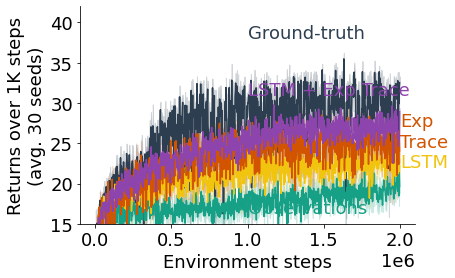

In [16]:
# with slip
fig, ax = plt.figure(), plt.axes()

fig_path = Path(ROOT_DIR, 'results', 'uf4_no_buffer_results.pdf')

for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_ylim(15, 42)
# ax.set_ylim(15, 30)

# ax.set_yticks([18, 22, 26])
ax.set_xlabel('Environment steps')
# ax.set_ylabel(f"Returns (1K steps)", rotation=0, labelpad=65)
ax.set_ylabel(f"Returns over 1K steps\n(avg. 30 seeds)")
# ax.yaxis.set_label_coords(-0.15, 0.65)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.text(2e6, 16.3, "Observations", color=plot_info[f'uf{level}m_cnn']['color'], fontdict=dict(size=18))
plt.text(1e6, 16.3, "Observations", color=plot_info[f'uf{level}m_cnn']['color'], fontdict=dict(size=18))

# plt.text(1.5e6, 33.5, "Ground-truth", color=plot_info[f'uf{level}a_cnn']['color'], fontdict=dict(size=18))
plt.text(1e6, 38, "Ground-truth", color=plot_info[f'uf{level}a_cnn']['color'], fontdict=dict(size=18))
# plt.text(6.1e6, 24, "Exp\nTrace", color=plot_info[f'uf{level}m_cnn_unc']['color'], fontdict=dict(size=18))
plt.text(2e6, 24.5, "Exp\nTrace", color=plot_info[f'uf{level}m_cnn_unc']['color'], fontdict=dict(size=18))

# plt.text(6.1e6, 21.5, "LSTM", color=plot_info[f'uf{level}m_cnn_lstm']['color'], fontdict=dict(size=18))
plt.text(2e6, 22, "LSTM", color=plot_info[f'uf{level}m_cnn_lstm']['color'], fontdict=dict(size=18))

# plt.text(1.5e6, 27.5, "LSTM + Exp Trace", color=plot_info[f'uf{level}m_cnn_lstm_unc']['color'], fontdict=dict(size=18))
plt.text(1e6, 31, "LSTM + Exp Trace", color=plot_info[f'uf{level}m_cnn_lstm_unc']['color'], fontdict=dict(size=18))

# ax.set_title(f'Fishing Environment')

# plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
fig.savefig(fig_path, bbox_inches='tight')



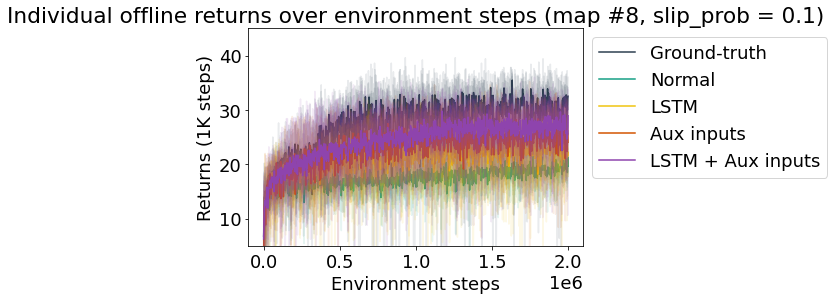

In [17]:
# with slip
fig, ax = plt.figure(), plt.axes()


for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    ax.plot(x, means, label=key, color=color)

    for d in data:
        ax.plot(x, d, color=color, alpha=0.1)
#     plt.fill_between(x, means - std_err, means + std_err,
#                          color=color, alpha=0.2)

ax.set_ylim(5, 45)
    
ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns (1K steps)")
ax.set_title(f'Individual offline returns over environment steps (map #8, slip_prob = 0.1)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [18]:
# hparam_results_dir = Path(ROOT_DIR, 'results', 'results_uf8_12m_hparam')
# all_hparam_paths = {
#     f'uf{level}a_cnn': hparam_results_dir / f'uf{level}a_cnn',
#     f'uf{level}m_cnn':  hparam_results_dir / f'uf{level}m_cnn',
#     f'uf{level}m_cnn_lstm':  hparam_results_dir / f'uf{level}m_cnn_lstm',
# }


In [19]:
raw_hparam_data = raw_data

In [20]:
key = 'trunc'
split_files = [f'uf{level}m_cnn_lstm']
trunc_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_hparam_data[split_file], key, split_file)
    for k, v in new_grouped.items():
        trunc_raw[k] = v
        
# for k, v in raw_data.items():
#     if k not in split_files:
#         new_raw[k] = v

In [21]:
max_overs_trunc = {}

for g, v in trunc_raw.items():
    max_overs_trunc[g] = get_eps_max_over(v, eps_max_over=0)


In [22]:
# Get the best hyperparams based on the final 100 episodes
all_best_trunc = {}
for key, v in max_overs_trunc.items():
    filtered_v = [el for el in v if el[0].uncertainty_decay == 1.]
        
    all_best_trunc[key] = sorted(filtered_v, key=lambda x : x[1], reverse=True)[0]

all_best_trunc

{'uf4m_cnn_lstm_trunc_1': (args(buffer_size=20000, step_size=1e-05, arch='cnn_lstm', uncertainty_decay=1.0, slip_prob=0.1, trunc=1, total_steps=2000000),
  18.78446,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn_lstm/27a9093f97c710fb9e148c1232e2d432_Thu Aug 11 10:03:42 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn_lstm/160e5ed54dbffc11af96e43fbfbbbc86_Thu Aug 11 10:03:42 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn_lstm/2e83ebab7fdd3f7d265525e75e144f56_Tue Aug  9 14:08:24 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn_lstm/aa9e1dfe023427c9a51679241fc0edbb_Thu Aug 11 10:04:33 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn_lstm/fa4e31ea917786230ca09a2376b192bc_Thu Aug 11 10:03:42 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents

In [23]:
# trunc = int(1e6)
all_mapped_data_trunc = {}

for key, v in all_best_trunc.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc[key] = np.stack(all_seeds)
    


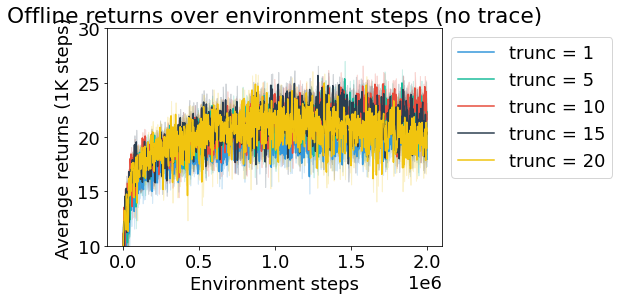

In [38]:
# with trunc

plot_info_trunc = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': 'trunc = 1'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': 'trunc = 5'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': 'trunc = 10'},
    f'uf{level}m_cnn_lstm_trunc_15': {'color': midnight_blue, 'label': 'trunc = 15'},
    f'uf{level}m_cnn_lstm_trunc_20': {'color': sunflower, 'label': 'trunc = 20'}

}

fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)
ax.set_ylim(10, 30)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)")
ax.set_title(f'Offline returns over environment steps (no trace)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

[1, 5, 10, 15, 20]

/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_2777/2030756335.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_2777/2030756335.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_2777/2030756335.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_2777/203075

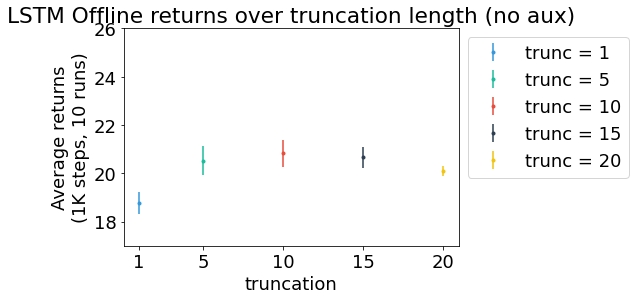

In [53]:
fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
# ax.set_xlim(0, 11)
ax.set_ylim(17, 26)

ax.set_xticks(sorted(list(int(key.split('_')[-1]) for key in plot_info_trunc.keys())))
ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns\n(1K steps, 10 runs)")
ax.set_title(f'LSTM Offline returns over truncation length (no aux)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [27]:
all_best_trunc_unfiltered = {}
for key, v in max_overs_trunc.items():
        
    all_best_trunc_unfiltered[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

# trunc = int(1e6)
all_mapped_data_trunc_unfiltered = {}

for key, v in all_best_trunc_unfiltered.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc_unfiltered[key] = np.stack(all_seeds)
    
all_best_trunc_unfiltered

{'uf4m_cnn_lstm_trunc_1': (args(buffer_size=20000, step_size=0.0001, arch='cnn_lstm', uncertainty_decay=0.85, slip_prob=0.1, trunc=1, total_steps=2000000),
  21.66636,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn_lstm/292cc035788f5ce0f5276afd334b8313_Wed Aug 10 06:01:57 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn_lstm/0ef4e5dc04204a0f19e6f09ce166750e_Wed Aug 10 06:01:58 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn_lstm/392c25acd86ba53723e390076357a7da_Thu Aug 11 10:39:28 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn_lstm/2dd4c2541e1b0aab4efeb2be5fdce497_Thu Aug 11 10:39:28 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf4_no_buff/uf4m_cnn_lstm/1e2743aeeafc5124afa595744f945b87_Thu Aug 11 10:39:28 2022.npy'),
   PosixPath('/Users/ruoyutao/Documen

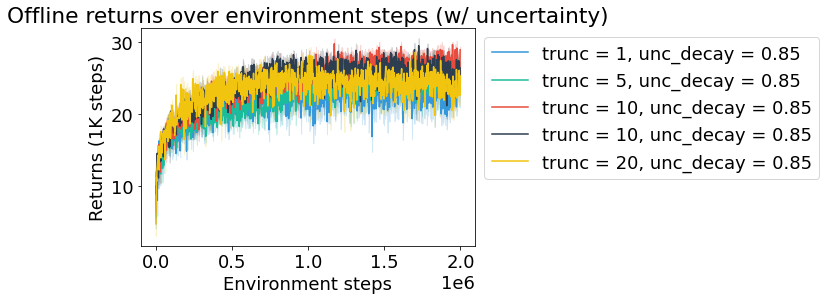

In [50]:
# with trunc

plot_info_trunc_unfiltered = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': f'trunc = 1, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_1"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': f'trunc = 5, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_5"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': f'trunc = 10, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_10"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_15': {'color': midnight_blue, 'label': f'trunc = 10, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_10"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_20': {'color': sunflower, 'label': f'trunc = 20, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_20"][0].uncertainty_decay}'}

}


fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)
ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns (1K steps)")
ax.set_title(f'Offline returns over environment steps (w/ uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

k: 1, step_means: [23.0632 17.6336 17.2822 17.4586 23.2674 24.3856 23.0298 22.1206 24.463
 23.9596]
k: 5, step_means: [24.5126 18.7852 18.8458 25.4552 23.3762 26.2666 22.3582 18.9822 22.955
 19.0278]
k: 10, step_means: [21.6634 21.5648 23.6746 23.9324 25.7186 25.5588 25.074  25.3286 25.4666
 25.1038]
k: 15, step_means: [24.2796 24.5332 24.6884 24.7422 23.0392 23.3686 24.4896 24.092  25.1262]
k: 20, step_means: [23.4606 22.885  22.6076 24.0882 23.064  24.055  23.4464 23.4622 23.5734]


/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_2777/3121553318.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_2777/3121553318.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_2777/3121553318.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_2777/312155

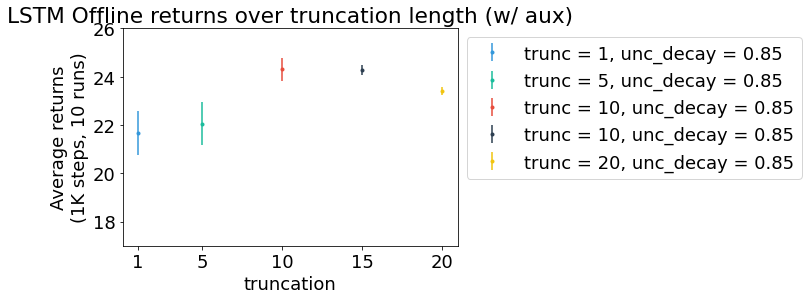

In [52]:
fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])
    print(f"k: {x.item()}, step_means: {step_means}")

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
# ax.set_xlim(0, 11)
ax.set_ylim(17, 26)

ax.set_xticks(sorted(list(int(key.split('_')[-1]) for key in plot_info_trunc.keys())))

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns\n(1K steps, 10 runs)")
ax.set_title(f'LSTM Offline returns over truncation length (w/ aux)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')